# Waste Classifier PyTorch Mobile Model Preparation

## 0 - Setup

In [1]:
import torch
import torchvision

print(torch.__version__) # 1.12+
print(torchvision.__version__) # 0.13+

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

from torchinfo import summary

import time
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
from helper_functions import download_data, set_seeds, plot_loss_curves

try:
    from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves
    print("Base imports done.")
except:
    print("Couldn't find helper scripts, downloading from Github...")
    !git clone https://github.com/tznpau/waste-classifier
    !mv waste-classifier/scripts .
    !mv waste-classifier/helper_functions.py .
    !rm -rf waste-classifier
    from scripts import data_setup, data_setup_augmented, engine, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves

2.1.1
0.16.1
Base imports done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1 - Getting data

In [3]:
trash_dataset_path = download_data(source="https://github.com/tznpau/waste-classifier/raw/main/data/trash_dataset.zip",
                                   destination="trash_dataset")
trash_dataset_path

[INFO] data\trash_dataset directory exists, skipping download.


WindowsPath('data/trash_dataset')

In [4]:
# Setup training and test data directories
train_dir = trash_dataset_path / "train"
test_dir = trash_dataset_path / "test"

train_dir, test_dir

(WindowsPath('data/trash_dataset/train'),
 WindowsPath('data/trash_dataset/test'))

## 2 - ResNet50 feature extractor

In [5]:
resnet50 = torchvision.models.resnet50()
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

#### Model class

In [6]:
def create_resnet50_model(num_classes:int=6,
                          dropout_prob:float=0.2):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        nn.Linear(in_features=2048, out_features=num_classes)
    ).to(device)

    return model

In [7]:
resnet50 = create_resnet50_model(num_classes=6, dropout_prob=0.3)

In [8]:
resnet50.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=6, bias=True)
)

#### Custom transforms

In [9]:
resnet50_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

resnet50_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
resnet50_train_transform

Compose(
    ToTensor()
    Resize(size=232, interpolation=bilinear, max_size=None, antialias=warn)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    RandomGrayscale(p=0.1)
    RandomHorizontalFlip(p=0.5)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [11]:
resnet50_test_transform

Compose(
    ToTensor()
    Resize(size=232, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

#### Dataloaders

In [12]:
from scripts import data_setup_augmented

train_dataloader_resnet50, test_dataloader_resnet50, class_names = data_setup_augmented.create_dataloaders(train_dir=train_dir,
                                                                                                           test_dir=test_dir,
                                                                                                           train_transform=resnet50_train_transform,
                                                                                                           test_transform=resnet50_test_transform,
                                                                                                           batch_size=32)

In [13]:
len(train_dataloader_resnet50), len(test_dataloader_resnet50), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

#### ResNet50 feature extractor summary

In [14]:
summary(resnet50,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 6]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

## 3 - Training

In [15]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(),
                             lr=1e-3)

resnet50_results = engine.train(model=resnet50,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                epochs=20,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2538 | train_acc: 0.6152 | test_loss: 0.8743 | test_acc: 0.7665
Epoch: 2 | train_loss: 0.8352 | train_acc: 0.7661 | test_loss: 0.7163 | test_acc: 0.7997
Epoch: 3 | train_loss: 0.6759 | train_acc: 0.8086 | test_loss: 0.5763 | test_acc: 0.8259
Epoch: 4 | train_loss: 0.5999 | train_acc: 0.8239 | test_loss: 0.5331 | test_acc: 0.8426
Epoch: 5 | train_loss: 0.5293 | train_acc: 0.8472 | test_loss: 0.4975 | test_acc: 0.8329
Epoch: 6 | train_loss: 0.5005 | train_acc: 0.8555 | test_loss: 0.4783 | test_acc: 0.8426
Epoch: 7 | train_loss: 0.4751 | train_acc: 0.8569 | test_loss: 0.4515 | test_acc: 0.8546
Epoch: 8 | train_loss: 0.4556 | train_acc: 0.8537 | test_loss: 0.4371 | test_acc: 0.8588
Epoch: 9 | train_loss: 0.4241 | train_acc: 0.8716 | test_loss: 0.4178 | test_acc: 0.8697
Epoch: 10 | train_loss: 0.4073 | train_acc: 0.8748 | test_loss: 0.4029 | test_acc: 0.8742
Epoch: 11 | train_loss: 0.3760 | train_acc: 0.8940 | test_loss: 0.3842 | test_acc: 0.8694
Epoch: 12 | train_l

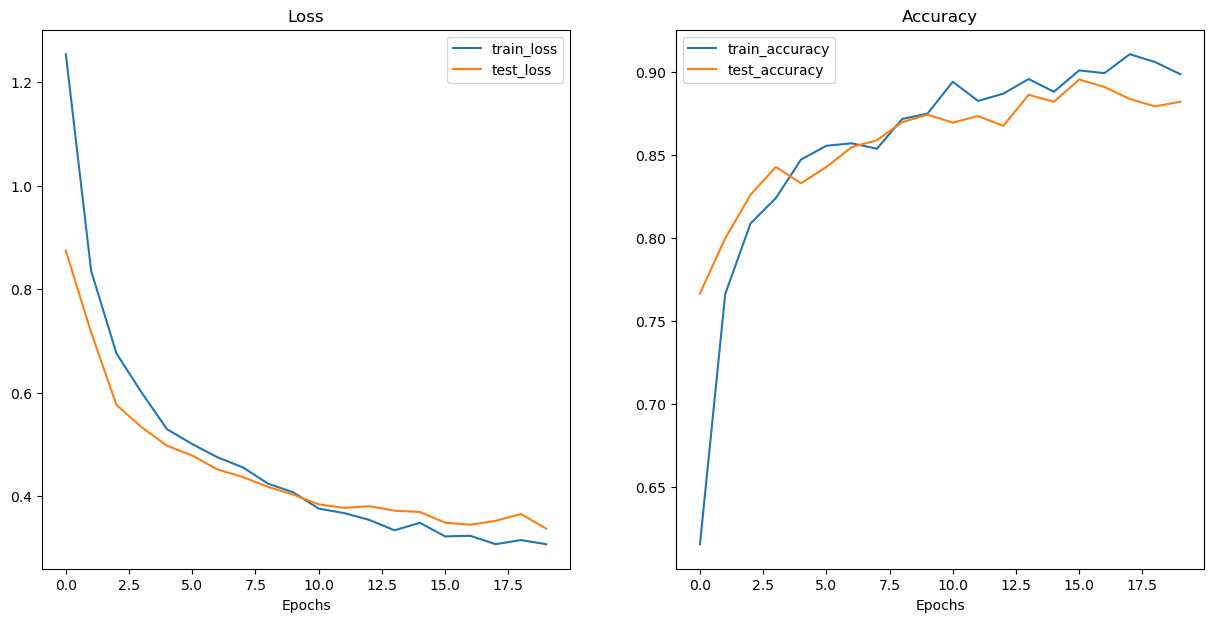

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results)

## 4 - Saving model & stats

In [17]:
from scripts import utils

utils.save_model(model=resnet50,
                 target_dir="models",
                 model_name="resnet50_model.pth")

Saving model to: models\resnet50_model.pth


In [18]:
from pathlib import Path

resnet50_total_params = sum(torch.numel(param) for param in resnet50.parameters())
size_resnet50 = Path("models/resnet50_model.pth").stat().st_size // (1024*1024)

In [19]:
from pathlib import Path

print(f"Finding all files ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

Finding all files ending with '.jpg' in directory: data\trash_dataset\test


[WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard11.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard110.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard117.jpg')]

In [20]:
from scripts import predictions

resnet50_test_predictions = predictions.pred_and_store(paths=test_data_paths,
                                                     model=resnet50,
                                                     transform=resnet50_test_transform,
                                                     class_names=class_names,
                                                     device="cpu")

  0%|          | 0/508 [00:00<?, ?it/s]

In [21]:
resnet50_test_predictions[:2]

[{'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9995,
  'pred_class': 'cardboard',
  'time_for_pred': 0.226,
  'correct': True},
 {'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9971,
  'pred_class': 'cardboard',
  'time_for_pred': 0.0681,
  'correct': True}]

In [22]:
resnet50_test_predictions_df = pd.DataFrame(resnet50_test_predictions)

resnet50_test_predictions_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\trash_dataset\test\cardboard\cardboard103...,cardboard,0.9995,cardboard,0.2260,True
1,data\trash_dataset\test\cardboard\cardboard104...,cardboard,0.9971,cardboard,0.0681,True
2,data\trash_dataset\test\cardboard\cardboard11.jpg,cardboard,0.9947,cardboard,0.0699,True
3,data\trash_dataset\test\cardboard\cardboard110...,cardboard,0.9804,cardboard,0.0735,True
4,data\trash_dataset\test\cardboard\cardboard117...,cardboard,0.9884,cardboard,0.0737,True


In [23]:
resnet50_test_predictions_df.correct.value_counts()

correct
True     449
False     59
Name: count, dtype: int64

In [24]:
resnet50_average_time_per_pred = round(resnet50_test_predictions_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {resnet50_average_time_per_pred} seconds")

Average time per prediction: 0.0728 seconds


In [25]:
resnet50_stats = {
    "test_loss" : resnet50_results["test_loss"][-1],
    "test_acc" : resnet50_results["test_acc"][-1],
    "total_number_of_parameters" : resnet50_total_params,
    "model_size (MB)" : size_resnet50,
    "time_per_pred_cpu (s)" : resnet50_average_time_per_pred
}

resnet50_stats

{'test_loss': 0.337243583984673,
 'test_acc': 0.8819754464285714,
 'total_number_of_parameters': 23520326,
 'model_size (MB)': 90,
 'time_per_pred_cpu (s)': 0.0728}

## 5 - Prediction on custom image

In [26]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model = model.cpu()
    model.eval()

    img = Image.open(img_path)
    img = resnet50_test_transform(img)
    img = img.unsqueeze(0)
    img = img.to('cpu')

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)
        print(f'Preds: {outputs}')

In [27]:
custom_image_path = Path("data/aluminum-cans-1.jpg")

NameError: name 'imshow' is not defined

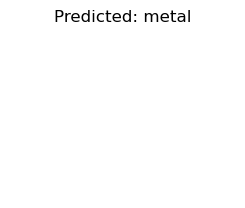

In [28]:
visualize_model_predictions(
    resnet50,
    img_path=custom_image_path
)

plt.ioff()
plt.show()